In [1]:
# Cell 1: Basic imports and setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import sys

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

sys.path.append('../MCEq')
os.chdir('..')

#import solver related modules
#import primary model choices
import crflux.models as pm
import crflux.models as crf

from MCEq.core import MCEqRun
#from MCEq import config
import MCEq.config as config
from MCEq.particlemanager import MCEqParticle

# Configure MCEq database paths
config.mceq_db_fname = "/opt/anaconda3/lib/python3.12/site-packages/MCEq/data/mceq_db_lext_dpm191_v12.h5"
config.decay_db_name = "full_decays"
config.muon_helicity_dependence = True

In [2]:
# Cell 2: Define the compute_mceq_fluxes function
def compute_mceq_fluxes(months=None, cos_max=1, cos_min=-1, n_angles=100, density_model="MSIS00_IC", interaction_model="SIBYLL-2.3", primary_model=(crf.HillasGaisser2012, "H3a"), location='SouthPole'):
    """
    Compute MCEq fluxes for multiple months and zenith angles (cos-spaced).

    Parameters:
    - months (list of str): List of months. Defaults to all 12.
    - n_angles (int): Number of cos-spaced zenith angles between 0 and 180 degrees.
    - density_model (str): A model describing the air density at different heights.
    - interaction_model (str): High-energy hadronic interaction model. Examples: 'DPMJet-III-19.1', 'DPMJet-III-3.0.6', 'EPOS-LHC', 'QGSJet-II-04', 'QGSJet-II-03', 'QGSJet-01c', 'SIBYLL-2.3c', 'SIBYLL-2.1'
    - primary_model (tuple): Cosmic ray flux model (model, name).
    - location (str): Location string for MSIS00_IC model (default: 'SouthPole').

    Returns:
    - dict with energy grid, zenith angles, and fluxes (total, conv, prompt).
    """

    if months is None:
        months = [
            'January', 'February', 'March', 'April', 'May', 'June',
            'July', 'August', 'September', 'October', 'November', 'December'
        ]

    # Create cos-spaced zenith angles from 0° to 180°
    angles_cos = np.linspace(cos_max, cos_min, n_angles)
    angles_deg = np.degrees(np.arccos(angles_cos))

    # Initialize MCEq
    mceq_run = MCEqRun(
        interaction_model=interaction_model,
        primary_model=primary_model,
        theta_deg=0.,                               # Temporary, will be overwritten
        e_bins=0.                                   # Temporary, will be overwritten
    )

    # Initialize storage
    total_fluxes = {"nue": {}, "numu": {}, "nutau": {}}

    # Loop over months and angles
    for month in months:
        mceq_run.set_density_model((density_model, (location, month)))

        # Temp storage for this month
        total_theta = {"nue": [], "numu": [], "nutau": []}
        conv_theta = {"nue": [], "numu": [], "nutau": []}
        prompt_theta = {"nue": [], "numu": [], "nutau": []}

        for theta in angles_deg:
            mceq_run.set_theta_deg(theta)
            mceq_run.solve()

            for flavor in ["nue", "numu", "nutau"]:
                total_flux = (
                    mceq_run.get_solution(f"total_{flavor}")
                    + mceq_run.get_solution(f"total_anti{flavor}")
                )

                total_theta[flavor].append(total_flux)

        # Store per month as arrays
        for flavor in ["nue", "numu", "nutau"]:
            total_fluxes[flavor][month] = np.array(total_theta[flavor])

    # Initialize outputs
    zenith_avg_fluxes = {}
    monthly_avg_fluxes = {}
    avg_total_fluxes = {}

    for flavor in ["nue", "numu", "nutau"]:
        # Stack monthly fluxes: shape (12, n_zenith, n_energy)
        stacked_months = np.stack([total_fluxes[flavor][month] for month in months], axis=0)

        # Average over months only (preserve zenith): (n_zenith, n_energy)
        zenith_avg_fluxes[flavor] = np.mean(stacked_months, axis=0)

        # Average over months *and* zenith: (n_energy,)
        avg_total_fluxes[flavor] = np.mean(stacked_months, axis=(0, 1))

        # Monthly full-sky averages: store as {month: (n_energy,) }
        monthly_avg_fluxes[flavor] = {
            month: np.mean(total_fluxes[flavor][month], axis=0) for month in months
        }

    # Return final structured result
    return {
        "e_grid": mceq_run.e_grid,
        "zen_grid": angles_deg,
        "zenith_avg": zenith_avg_fluxes,
        "monthly_avg": monthly_avg_fluxes,
        "average_total": avg_total_fluxes,
    }

In [3]:
# Cell 3: Compute fluxes for different angular ranges using the function
# Define angular ranges: 0-85°, 85-100°, 100-120°, 120-180°

# 0-85° range (cosθ from 1 to cos(85°))
print("Computing fluxes for 0-85° range...")
MCEq_data_0_85 = compute_mceq_fluxes(months=None, cos_max=1, cos_min=np.cos(np.radians(85)), 
                                    n_angles=30, density_model="MSIS00_IC", 
                                    interaction_model="SIBYLL-2.3c", 
                                    primary_model=(crf.HillasGaisser2012, "H3a"), 
                                    location='SouthPole')

# 85-100° range (cosθ from cos(85°) to cos(100°))
print("Computing fluxes for 85-100° range...")
MCEq_data_85_100 = compute_mceq_fluxes(months=None, cos_max=np.cos(np.radians(85)), cos_min=np.cos(np.radians(100)), 
                                      n_angles=30, density_model="MSIS00_IC", 
                                      interaction_model="SIBYLL-2.3c", 
                                      primary_model=(crf.HillasGaisser2012, "H3a"), 
                                      location='SouthPole')

# 100-120° range (cosθ from cos(100°) to cos(120°))
print("Computing fluxes for 100-120° range...")
MCEq_data_100_120 = compute_mceq_fluxes(months=None, cos_max=np.cos(np.radians(100)), cos_min=np.cos(np.radians(120)), 
                                       n_angles=30, density_model="MSIS00_IC", 
                                       interaction_model="SIBYLL-2.3c", 
                                       primary_model=(crf.HillasGaisser2012, "H3a"), 
                                       location='SouthPole')

# 120-180° range (cosθ from cos(120°) to -1)
print("Computing fluxes for 120-180° range...")
MCEq_data_120_180 = compute_mceq_fluxes(months=None, cos_max=np.cos(np.radians(120)), cos_min=-1, 
                                       n_angles=30, density_model="MSIS00_IC", 
                                       interaction_model="SIBYLL-2.3c", 
                                       primary_model=(crf.HillasGaisser2012, "H3a"), 
                                       location='SouthPole')

# Also compute for EPOS-LHC model for comparison
print("Computing EPOS-LHC fluxes for 0-85° range...")
MCEq_data_epos_0_85 = compute_mceq_fluxes(months=None, cos_max=1, cos_min=np.cos(np.radians(85)), 
                                         n_angles=30, density_model="MSIS00_IC", 
                                         interaction_model="EPOS-LHC", 
                                         primary_model=(crf.HillasGaisser2012, "H3a"), 
                                         location='SouthPole')

print("Computing EPOS-LHC fluxes for 85-100° range...")
MCEq_data_epos_85_100 = compute_mceq_fluxes(months=None, cos_max=np.cos(np.radians(85)), cos_min=np.cos(np.radians(100)), 
                                           n_angles=30, density_model="MSIS00_IC", 
                                           interaction_model="EPOS-LHC", 
                                           primary_model=(crf.HillasGaisser2012, "H3a"), 
                                           location='SouthPole')

print("Computing EPOS-LHC fluxes for 100-120° range...")
MCEq_data_epos_100_120 = compute_mceq_fluxes(months=None, cos_max=np.cos(np.radians(100)), cos_min=np.cos(np.radians(120)), 
                                            n_angles=30, density_model="MSIS00_IC", 
                                            interaction_model="EPOS-LHC", 
                                            primary_model=(crf.HillasGaisser2012, "H3a"), 
                                            location='SouthPole')

print("Computing EPOS-LHC fluxes for 120-180° range...")
MCEq_data_epos_120_180 = compute_mceq_fluxes(months=None, cos_max=np.cos(np.radians(120)), cos_min=-1, 
                                            n_angles=30, density_model="MSIS00_IC", 
                                            interaction_model="EPOS-LHC", 
                                            primary_model=(crf.HillasGaisser2012, "H3a"), 
                                            location='SouthPole')

Computing fluxes for 0-85° range...
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 14.41
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 20.44
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 25.10
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 29.06
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 32.58
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 35.79
MSIS00IceCubeCentered::set_theta(): latitud

In [4]:
# Cell 4: Extract electron neutrino fluxes for plotting
# SIBYLL results
sibyll_0_85 = {
    'avg_total': MCEq_data_0_85['average_total']['nue'],
    'energy': MCEq_data_0_85['e_grid']
}

sibyll_85_100 = {
    'avg_total': MCEq_data_85_100['average_total']['nue'],
    'energy': MCEq_data_85_100['e_grid']
}

sibyll_100_120 = {
    'avg_total': MCEq_data_100_120['average_total']['nue'],
    'energy': MCEq_data_100_120['e_grid']
}

sibyll_120_180 = {
    'avg_total': MCEq_data_120_180['average_total']['nue'],
    'energy': MCEq_data_120_180['e_grid']
}

# EPOS results
epos_0_85 = {
    'avg_total': MCEq_data_epos_0_85['average_total']['nue'],
    'energy': MCEq_data_epos_0_85['e_grid']
}

epos_85_100 = {
    'avg_total': MCEq_data_epos_85_100['average_total']['nue'],
    'energy': MCEq_data_epos_85_100['e_grid']
}

epos_100_120 = {
    'avg_total': MCEq_data_epos_100_120['average_total']['nue'],
    'energy': MCEq_data_epos_100_120['e_grid']
}

epos_120_180 = {
    'avg_total': MCEq_data_epos_120_180['average_total']['nue'],
    'energy': MCEq_data_epos_120_180['e_grid']
}

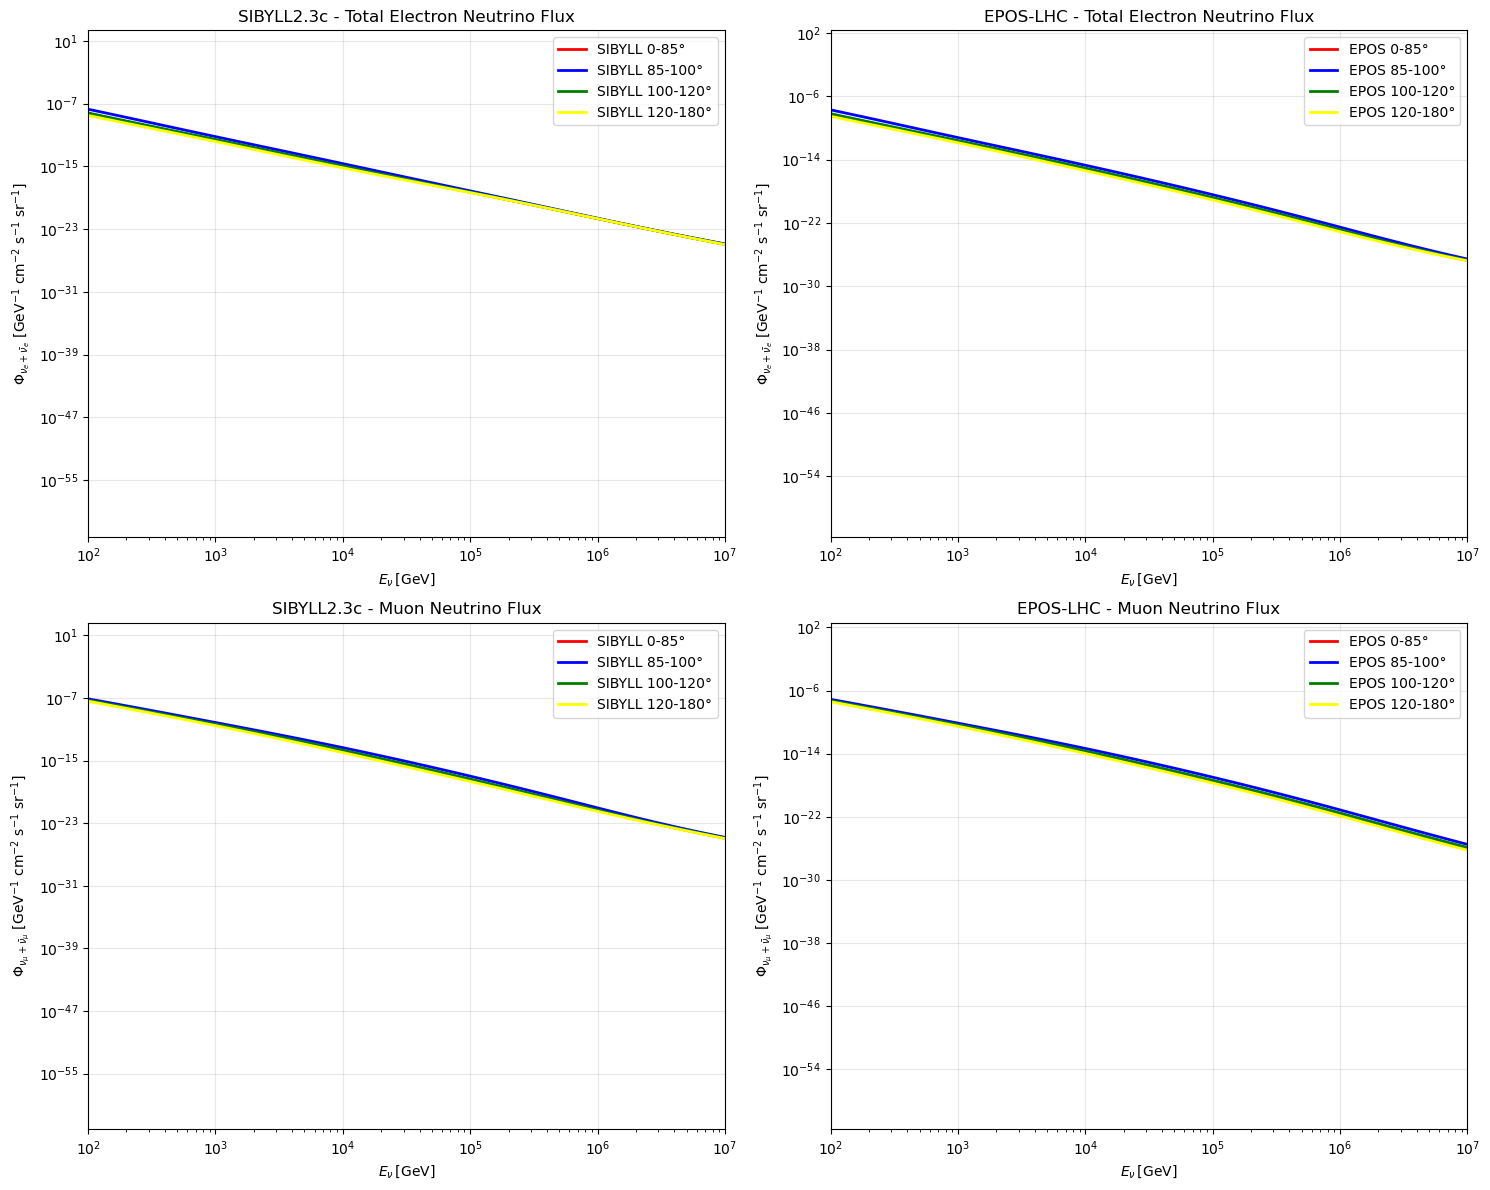

In [7]:
# Cell 5: Plot comparison - SIBYLL vs EPOS for electron neutrinos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
energy = sibyll_0_85['energy']

# Plot 1: SIBYLL - Total electron neutrino flux
ax1 = axes[0, 0]
# 0-85 degrees (red)
ax1.plot(energy, sibyll_0_85['avg_total'], 
         color='red', lw=2, label='SIBYLL 0-85°')
# 85-100 degrees (blue)  
ax1.plot(energy, sibyll_85_100['avg_total'], 
         color='blue', lw=2, label='SIBYLL 85-100°')
# 100-120 degrees (green)
ax1.plot(energy, sibyll_100_120['avg_total'], 
         color='green', lw=2, label='SIBYLL 100-120°')
# 120-180 degrees (yellow)
ax1.plot(energy, sibyll_120_180['avg_total'], 
         color='yellow', lw=2, label='SIBYLL 120-180°')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$E_{\nu}\,[\mathrm{GeV}]$')
ax1.set_ylabel(r'$\Phi_{\nu_e + \bar{\nu}_e}$ [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
ax1.set_title('SIBYLL2.3c - Total Electron Neutrino Flux')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1e2, 1e7)

# Plot 2: EPOS - Total electron neutrino flux
ax2 = axes[0, 1]
# 0-85 degrees (red)
ax2.plot(energy, epos_0_85['avg_total'], 
         color='red', lw=2, label='EPOS 0-85°')
# 85-100 degrees (blue)
ax2.plot(energy, epos_85_100['avg_total'], 
         color='blue', lw=2, label='EPOS 85-100°')
# 100-120 degrees (green)
ax2.plot(energy, epos_100_120['avg_total'], 
         color='green', lw=2, label='EPOS 100-120°')
# 120-180 degrees (yellow)
ax2.plot(energy, epos_120_180['avg_total'], 
         color='yellow', lw=2, label='EPOS 120-180°')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$E_{\nu}\,[\mathrm{GeV}]$')
ax2.set_ylabel(r'$\Phi_{\nu_e + \bar{\nu}_e}$ [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
ax2.set_title('EPOS-LHC - Total Electron Neutrino Flux')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1e2, 1e7)

# Plot 3: SIBYLL - Muon neutrino flux
ax3 = axes[1, 0]
# 0-85 degrees (red)
ax3.plot(energy, MCEq_data_0_85['average_total']['numu'], 
         color='red', lw=2, label='SIBYLL 0-85°')
# 85-100 degrees (blue)
ax3.plot(energy, MCEq_data_85_100['average_total']['numu'], 
         color='blue', lw=2, label='SIBYLL 85-100°')
# 100-120 degrees (green)
ax3.plot(energy, MCEq_data_100_120['average_total']['numu'], 
         color='green', lw=2, label='SIBYLL 100-120°')
# 120-180 degrees (yellow)
ax3.plot(energy, MCEq_data_120_180['average_total']['numu'], 
         color='yellow', lw=2, label='SIBYLL 120-180°')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'$E_{\nu}\,[\mathrm{GeV}]$')
ax3.set_ylabel(r'$\Phi_{\nu_\mu + \bar{\nu}_\mu}$ [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
ax3.set_title('SIBYLL2.3c - Muon Neutrino Flux')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(1e2, 1e7)

# Plot 4: EPOS - Muon neutrino flux
ax4 = axes[1, 1]
# 0-85 degrees (red)
ax4.plot(energy, MCEq_data_epos_0_85['average_total']['numu'], 
         color='red', lw=2, label='EPOS 0-85°')
# 85-100 degrees (blue)
ax4.plot(energy, MCEq_data_epos_85_100['average_total']['numu'], 
         color='blue', lw=2, label='EPOS 85-100°')
# 100-120 degrees (green)
ax4.plot(energy, MCEq_data_epos_100_120['average_total']['numu'], 
         color='green', lw=2, label='EPOS 100-120°')
# 120-180 degrees (yellow)
ax4.plot(energy, MCEq_data_epos_120_180['average_total']['numu'], 
         color='yellow', lw=2, label='EPOS 120-180°')

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel(r'$E_{\nu}\,[\mathrm{GeV}]$')
ax4.set_ylabel(r'$\Phi_{\nu_\mu + \bar{\nu}_\mu}$ [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
ax4.set_title('EPOS-LHC - Muon Neutrino Flux')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(1e2, 1e7)

plt.tight_layout()
plt.show()

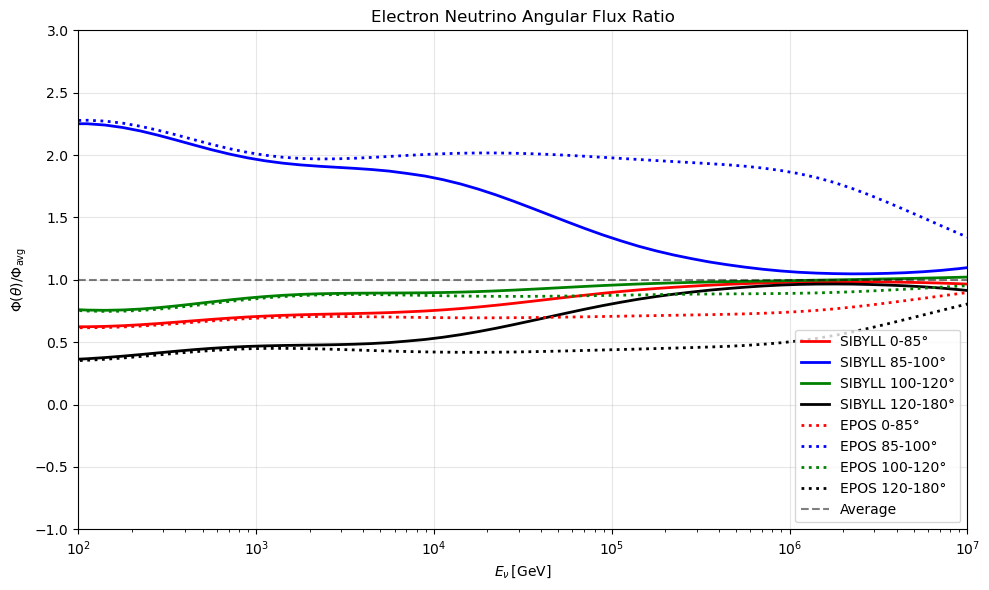

In [14]:
# Cell 6: Plot with angular flux ratio
fig, ax = plt.subplots(figsize=(10, 6))

energy = sibyll_0_85['energy']

# Calculate ratios: angular bin flux / total average flux
total_avg_sibyll = (sibyll_0_85['avg_total'] + sibyll_85_100['avg_total'] + 
                   sibyll_100_120['avg_total'] + sibyll_120_180['avg_total']) / 4
total_avg_epos = (epos_0_85['avg_total'] + epos_85_100['avg_total'] + 
                 epos_100_120['avg_total'] + epos_120_180['avg_total']) / 4

# SIBYLL - solid lines
# 0-85 degrees (red solid)
ax.plot(energy, sibyll_0_85['avg_total'] / total_avg_sibyll, 
        color='red', lw=2, linestyle='-', label='SIBYLL 0-85°')
# 85-100 degrees (blue solid)  
ax.plot(energy, sibyll_85_100['avg_total'] / total_avg_sibyll, 
        color='blue', lw=2, linestyle='-', label='SIBYLL 85-100°')
# 100-120 degrees (green solid)
ax.plot(energy, sibyll_100_120['avg_total'] / total_avg_sibyll, 
        color='green', lw=2, linestyle='-', label='SIBYLL 100-120°')
# 120-180 degrees (black solid)
ax.plot(energy, sibyll_120_180['avg_total'] / total_avg_sibyll, 
        color='black', lw=2, linestyle='-', label='SIBYLL 120-180°')

# EPOS - dotted lines
# 0-85 degrees (red dotted)
ax.plot(energy, epos_0_85['avg_total'] / total_avg_epos, 
        color='red', lw=2, linestyle=':', label='EPOS 0-85°')
# 85-100 degrees (blue dotted)
ax.plot(energy, epos_85_100['avg_total'] / total_avg_epos, 
        color='blue', lw=2, linestyle=':', label='EPOS 85-100°')
# 100-120 degrees (green dotted)
ax.plot(energy, epos_100_120['avg_total'] / total_avg_epos, 
        color='green', lw=2, linestyle=':', label='EPOS 100-120°')
# 120-180 degrees (black dotted)
ax.plot(energy, epos_120_180['avg_total'] / total_avg_epos, 
        color='black', lw=2, linestyle=':', label='EPOS 120-180°')

# Add reference line at y=1
ax.axhline(1.0, color='black', linestyle='--', alpha=0.5, label='Average')

ax.set_xscale('log')
ax.set_xlabel(r'$E_{\nu}\,[\mathrm{GeV}]$')
ax.set_ylabel(r'$\Phi(\theta) / \Phi_{\mathrm{avg}}$')
ax.set_title('Electron Neutrino Angular Flux Ratio')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(1e2, 1e7)
ax.set_ylim(-1, 3)  

plt.tight_layout()
plt.show()